In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dataset_path = '/content/drive/My Drive/Facial_Emotion_Recognition_Project/FER_25'

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

IMG_SIZE = (224, 224)
BATCH_SIZE = 512

# Data augmentation and preprocessing
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

# Load training data
train_generator = datagen.flow_from_directory(
    '/content/drive/My Drive/Facial_Emotion_Recognition_Project/FER_25/Train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
)

# Load validation data
validation_generator = datagen.flow_from_directory(
    '/content/drive/My Drive/Facial_Emotion_Recognition_Project/FER_25/Train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
)
# Load and preprocess test images
test_generator = datagen.flow_from_directory(
    '/content/drive/My Drive/Facial_Emotion_Recognition_Project/FER_25/Test',  # Path to the test dataset
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 5846 images belonging to 7 classes.
Found 647 images belonging to 7 classes.
Found 717 images belonging to 7 classes.


In [4]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam

# Create Precision and Recall metrics outside the function
precision_metric = Precision()
recall_metric = Recall()

# Custom F1-score metric
def f1_score(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)  # Use pre-created metric
    recall = recall_metric(y_true, y_pred)      # Use pre-created metric
    f1 = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
    return f1

# Apply mixed precision for faster training and less GPU load
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Load pre-trained EfficientNetB3 model without the top classification layer
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model to retain pre-trained weights
base_model.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
# Apply the output layer to the previous layer's output
output = Dense(7, activation='softmax')(x)  # 7 classes: anger, disgust, fear, happiness, neutral, sadness and surprise

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), f1_score]
)
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1404s 115s/step - accuracy: 0.2889 - f1_score: 0.0499 - loss: 1.7867 - precision: 0.6061 - recall: 0.0624 - val_accuracy: 0.4316 - val_f1_score: 0.2111 - val_loss: 1.5380 - val_precision: 0.5843 - val_recall: 0.2031
Epoch 2/30
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.4883 - f1_score: 0.2265 - loss: 1.4368 - precision: 0.6522 - recall: 0.2637

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 643ms/step - accuracy: 0.4883 - f1_score: 0.2265 - loss: 1.4368 - precision: 0.6522 - recall: 0.2637 - val_accuracy: 0.4277 - val_f1_score: 0.2334 - val_loss: 1.5004 - val_precision: 0.5838 - val_recall: 0.2109
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 70s 7s/step - accuracy: 0.5154 - f1_score: 0.2633 - loss: 1.3391 - precision: 0.7011 - recall: 0.2759 - val_accuracy: 0.4746 - val_f1_score: 0.3190 - val_loss: 1.4253 - val_precision: 0.6114 - val_recall: 0.2520
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 774ms/step - accuracy: 0.5215 - f1_score: 0.3239 - loss: 1.2798 - precision: 0.6894 - recall: 0.3164 - val_accuracy: 0.4609 - val_f1_score: 0.3245 - val_loss: 1.4355 - val_precision: 0.6091 - val_recall: 0.2344
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 70s 6s/step - accuracy: 0.5522 - f1_score: 0.3427 - loss: 1.2091 - precision: 0.7380 - recall: 0.3499 - val_accuracy: 0.4883 - val_f1_score: 0.3751 - val_loss: 1.3306 - val_precision: 0.6805 - val_recall: 0.3203
Epoch 6

In [6]:
# Evaluate the model and unpack the returned values appropriately
test_loss, test_accuracy, test_precision, test_recall, test_f1_score = model.evaluate(validation_generator)

# Print the test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 51s 45s/step - accuracy: 0.6047 - f1_score: 0.5666 - loss: 1.1013 - precision: 0.7058 - recall: 0.4822
Test Accuracy: 60.43%


In [7]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Use a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), f1_score]
)

# Fine-tune the model
fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,  # Add more epochs for fine-tuning
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 579s 25s/step - accuracy: 0.3497 - f1_score: 0.5618 - loss: 1.7844 - precision: 0.4481 - recall: 0.2071 - val_accuracy: 0.5039 - val_f1_score: 0.5561 - val_loss: 1.4586 - val_precision: 0.5586 - val_recall: 0.4375
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 642ms/step - accuracy: 0.5371 - f1_score: 0.5559 - loss: 1.2402 - precision: 0.6775 - recall: 0.4062 - val_accuracy: 0.5391 - val_f1_score: 0.5558 - val_loss: 1.5056 - val_precision: 0.5931 - val_recall: 0.4727
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 71s 6s/step - accuracy: 0.5983 - f1_score: 0.5559 - loss: 1.0854 - precision: 0.7070 - recall: 0.4720 - val_accuracy: 0.5762 - val_f1_score: 0.5577 - val_loss: 1.3095 - val_precision: 0.6494 - val_recall: 0.5391
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 743ms/step - accuracy: 0.6660 - f1_score: 0.5580 - loss: 0.9160 - precision: 0.7408 - recall: 0.5527 - val_accuracy: 0.5820 - val_f1_score: 0.5582 - val_loss: 1.2278 - val_precision: 0.6445 - val_recall: 0

In [8]:
# Evaluate the model and unpack the returned values appropriately
test_loss, test_accuracy, test_precision, test_recall, test_f1_score = model.evaluate(validation_generator)

# Print the test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 8s/step - accuracy: 0.8003 - f1_score: 0.6896 - loss: 0.6674 - precision: 0.8088 - recall: 0.7909
Test Accuracy: 79.91%


In [9]:
import numpy as np
from tensorflow.keras.preprocessing import image
import os

# Define the path to the Anger folder
anger_folder_path = '/content/drive/My Drive/Facial_Emotion_Recognition_Project/FER_25/Test/Anger'

# Get a list of all image files in the Anger folder
image_files = [f for f in os.listdir(anger_folder_path) if os.path.isfile(os.path.join(anger_folder_path, f))]

# Define your emotion categories
emotion_categories = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']

# Loop through each image file and make a prediction
for image_file in image_files:
    # Construct the full path to the image
    img_path = os.path.join(anger_folder_path, image_file)

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make the prediction
    prediction = model.predict(img_array)

    # Get the predicted class index and emotion label
    predicted_class_index = np.argmax(prediction)
    predicted_emotion = emotion_categories[predicted_class_index]

    # Print the prediction for the current image
    print(f"Image: {image_file}, Predicted emotion: {predicted_emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
Image: anger_1001.jpg, Predicted emotion: Anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Image: anger_121.jpg, Predicted emotion: Happiness
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Image: anger_128.jpg, Predicted emotion: Anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Image: anger_102.jpg, Predicted emotion: Anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Image: anger_13.jpg, Predicted emotion: Anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Image: anger_126.jpg, Predicted emotion: Happiness
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Image: anger_196.jpg, Predicted emotion: Anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Image: anger_167.jpg, Predicted emotion: Anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Image: anger_182.jpg, Predicted emotion: Anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Image: anger_190.jpg, Predicted emotion: Anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Image: anger_176.jpg, Predicted emotion: Anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Image: anger_187.jp

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

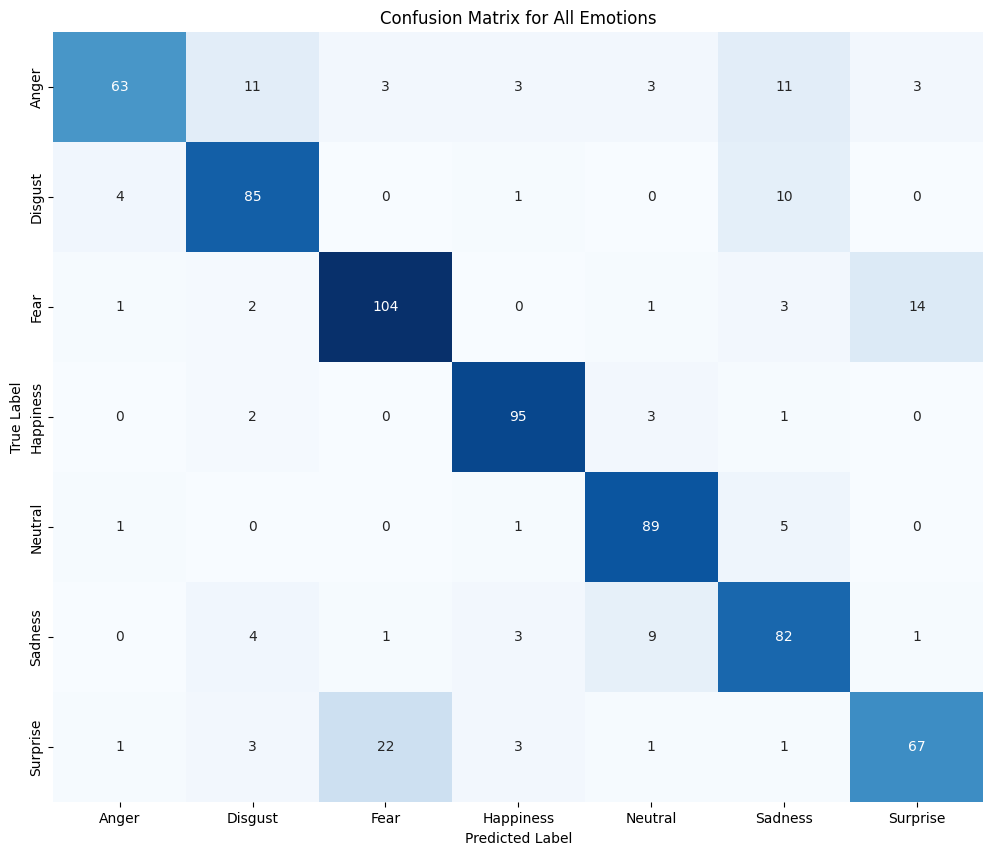

In [10]:
import numpy as np
import os
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define your emotion categories
emotion_categories = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']

# Initialize empty lists to store all predicted and true emotions
all_predicted_emotions = []
all_true_emotions = []

# Loop through each emotion category
for emotion in emotion_categories:
    # Define the path to the emotion folder
    emotion_folder_path = os.path.join('/content/drive/My Drive/Facial_Emotion_Recognition_Project/FER_25/Test', emotion)

    # Get a list of all image files in the emotion folder
    image_files = [f for f in os.listdir(emotion_folder_path) if os.path.isfile(os.path.join(emotion_folder_path, f))]

    # Loop through each image file and make a prediction
    for image_file in image_files:
        # Construct the full path to the image
        img_path = os.path.join(emotion_folder_path, image_file)

        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Make the prediction
        prediction = model.predict(img_array)

        # Get the predicted class index and emotion label
        predicted_class_index = np.argmax(prediction)
        predicted_emotion = emotion_categories[predicted_class_index]

        # Append the predicted and true emotions to the lists
        all_predicted_emotions.append(predicted_emotion)
        all_true_emotions.append(emotion)  # True emotion is the current emotion category

# Convert the lists to NumPy arrays
all_predicted_emotions = np.array(all_predicted_emotions)
all_true_emotions = np.array(all_true_emotions)

# Create the confusion matrix
cm_all_emotions = confusion_matrix(all_true_emotions, all_predicted_emotions, labels=emotion_categories)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(cm_all_emotions, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=emotion_categories, yticklabels=emotion_categories)
plt.title("Confusion Matrix for All Emotions")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [23]:
import numpy as np
import os
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.efficientnet import preprocess_input # Assuming you used EfficientNet's preprocessing

# Define emotion categories
emotion_categories = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']

# Path to your Anger test folder
anger_folder_path = '/content/drive/My Drive/Facial_Emotion_Recognition_Project/FER_25/Test/Anger'

true_labels = []
predicted_labels = []

# Loop through images in the Anger folder
for image_file in os.listdir(anger_folder_path):
    img_path = os.path.join(anger_folder_path, image_file)
    img = image.load_img(img_path, target_size=(224, 224))  # Adjust target_size if needed
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)

    # Append labels
    true_labels.append(0)  # Anger is at index 0
    predicted_labels.append(predicted_class_index)

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=range(len(emotion_categories)))

# Extract TP, FP, TN, FN for Anger (index 0)
TP = cm[0, 0]
FP = sum(cm[i,0] for i in range(len(emotion_categories)) if i!=0)
FN = sum(cm[0,i] for i in range(len(emotion_categories)) if i!=0)
TN = sum(cm[i, j] for i in range(len(emotion_categories)) for j in range(len(emotion_categories)) if i != 0 and j != 0)


print("For Anger Emotion:")
print("True Positives (TP):", TP)
print("False Positives (FP):", FP)
print("True Negatives (TN):", TN)
print("False Negatives (FN):", FN)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

In [27]:
import numpy as np
import os
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.efficientnet import preprocess_input

# Define emotion categories
emotion_categories = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']

# Path to your Test folder
test_folder_path = '/content/drive/My Drive/Facial_Emotion_Recognition_Project/FER_25/Test'

true_labels = []
predicted_labels = []

# Loop through each emotion category folder in the Test folder
for emotion_index, emotion in enumerate(emotion_categories):
    emotion_folder_path = os.path.join(test_folder_path, emotion)

    # Loop through images in the emotion folder
    for image_file in os.listdir(emotion_folder_path):
        img_path = os.path.join(emotion_folder_path, image_file)
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Make prediction
        prediction = model.predict(img_array)
        predicted_class_index = np.argmax(prediction)

        # Append labels
        true_labels.append(emotion_index)  # Use emotion_index for true label
        predicted_labels.append(predicted_class_index)

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=range(len(emotion_categories)))

# Print TP, FP, TN, FN for each emotion
for emotion_index, emotion in enumerate(emotion_categories):
    TP = cm[emotion_index, emotion_index]
    FP = sum(cm[i, emotion_index] for i in range(len(emotion_categories)) if i != emotion_index)
    FN = sum(cm[emotion_index, i] for i in range(len(emotion_categories)) if i != emotion_index)
    TN = sum(cm[i, j] for i in range(len(emotion_categories)) for j in range(len(emotion_categories)) if i != emotion_index and j != emotion_index)

    print(f"For {emotion} Emotion:")
    print("True Positives (TP):", TP)
    print("False Positives (FP):", FP)
    print("True Negatives (TN):", TN)
    print("False Negatives (FN):", FN)
    print("-" * 20)  # Separator between emotions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

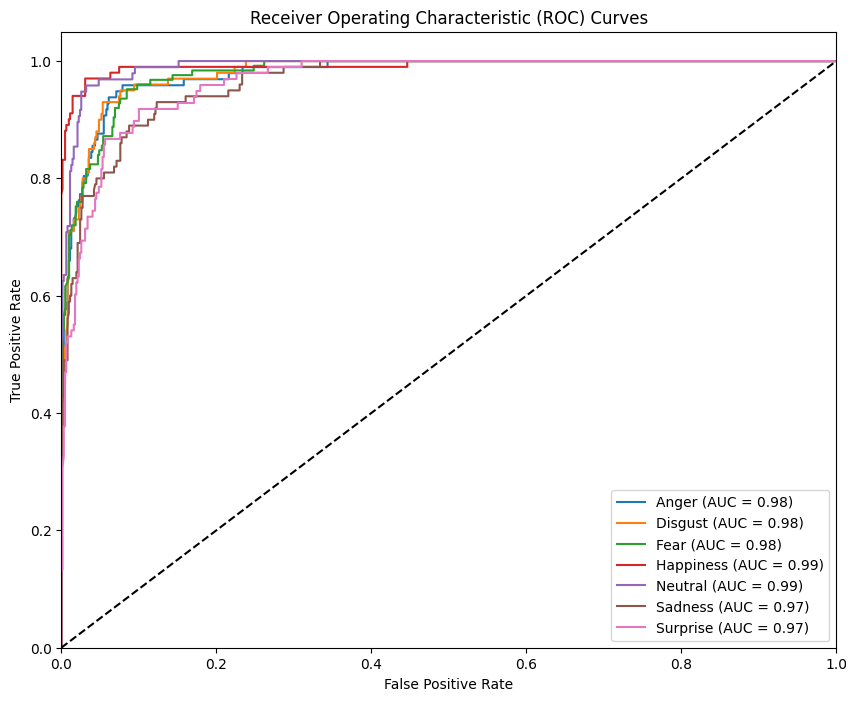

In [28]:
import numpy as np
import os
from tensorflow.keras.preprocessing import image
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.applications.efficientnet import preprocess_input
import matplotlib.pyplot as plt

# Define emotion categories
emotion_categories = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']

# Path to your Test folder
test_folder_path = '/content/drive/My Drive/Facial_Emotion_Recognition_Project/FER_25/Test'

# Initialize lists to store true and predicted probabilities for each class
true_labels = []
predicted_probabilities = []

# Loop through each emotion category folder in the Test folder
for emotion_index, emotion in enumerate(emotion_categories):
    emotion_folder_path = os.path.join(test_folder_path, emotion)

    # Loop through images in the emotion folder
    for image_file in os.listdir(emotion_folder_path):
        img_path = os.path.join(emotion_folder_path, image_file)
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Make prediction (get probabilities)
        prediction = model.predict(img_array)[0]  # Get probabilities for all classes

        # Append true label (one-hot encoded) and predicted probabilities
        true_label = np.zeros(len(emotion_categories))
        true_label[emotion_index] = 1  # One-hot encoding
        true_labels.append(true_label)
        predicted_probabilities.append(prediction)

# Convert lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_probabilities = np.array(predicted_probabilities)

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(len(emotion_categories)):
    fpr, tpr, _ = roc_curve(true_labels[:, i], predicted_probabilities[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{emotion_categories[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()